In [44]:
%matplotlib inline

from gensim.models import KeyedVectors
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib as mpl
import math, json

def normalize(phrase):
    if '(' in phrase:
        phrase = phrase[:phrase.index('(')]
    return '_'.join(phrase.lower().split())

In [2]:
word_vectors = KeyedVectors.load_word2vec_format('/data/lectures/diploma/data/ifora_wos_ngram.model.bin', binary=True)

In [3]:
folder = 'ml'
params = {}
corpus_occurence = pd.read_csv('../../data/%s/corpus_occurrence_by_year.csv' % folder, **params)
cooccurrence = pd.read_csv('../../data/%s/cooccurrence_by_year.csv' % folder, **params)
occurrence = pd.read_csv('../../data/%s/occurrence_by_year.csv' % folder, **params)
specificity = pd.read_csv('../../data/%s/specificity_statistics.csv' % folder, **params)

In [4]:
vocab = set(word_vectors.vocab)
len(vocab)

1540081

In [5]:
set1 = set(cooccurrence.ngram1) | set(cooccurrence.ngram2)
set2 = set(specificity.ngram)
set3 = set(occurrence.ngram)
ngrams = set1 & set2 & set3
len(set1), len(set2), len(set3), len(ngrams)

(19955, 19781, 19781, 19770)

In [24]:
json.dump(list(ngrams), open('../../data/%s/ngrams.json' % folder, 'w'))

In [6]:
data = {}
data_by_ngram = {}
not_matched = 0
for ngram in ngrams:
    token = normalize(ngram)
    if token not in vocab:
        not_matched += 1
        continue

    entry = {
        'ngram': ngram,
        'token': token,
        'vector': word_vectors.get_vector(token).tolist(),
        'cooc_by_year': {},
        'cooc': {},
        'oc_by_year': {},
        'oc': {},
    }
    if token in data:
        print(ngram, '|', data[token]['ngram'], '|', token)
    data_by_ngram[ngram] = entry
    data[token] = entry

print()
print('%d not matched' % not_matched)
print('%d matched' % len(data))


4542 not matched
15228 matched


In [7]:
for no, (ngram1, ngram2, pubyear, count) in cooccurrence.iterrows():
    if ngram1 not in data_by_ngram or ngram2 not in data_by_ngram:
        continue

    entry1 = data_by_ngram[ngram1]
    entry2 = data_by_ngram[ngram2]
    
    token1 = entry1['token']
    token2 = entry2['token']

    cooc_by_year1 = entry1['cooc_by_year']
    cooc_by_year2 = entry2['cooc_by_year']

    if pubyear not in cooc_by_year1:
        cooc_by_year1[pubyear] = {}
    if pubyear not in cooc_by_year2:
        cooc_by_year2[pubyear] = {}
    
    cooc_by_year1[pubyear][token2] = count
    cooc_by_year2[pubyear][token1] = count
    
for entry in data.values():
    entry['cooc'] = {}
    for year in entry['cooc_by_year']:
        for token2, count in entry['cooc_by_year'][year].items():
            if token2 not in entry['cooc']:
                entry['cooc'][token2] = 0
            entry['cooc'][token2] += count

In [8]:
for no, (ngram, pubyear, count, rel_freq) in occurrence.iterrows():
    if ngram not in data_by_ngram:
        continue
    
    entry = data_by_ngram[ngram]

    entry['oc_by_year'][pubyear] = {
        'count': count,
        'rel_freq': rel_freq,
    }
    
for entry in data.values():
    entry['oc'] = 0
    for year in entry['oc_by_year']:
        e = entry['oc_by_year'][year]
        entry['oc'] += e['count']

In [9]:
for no, (ngram, ngramids, local_count, local_sum, corpus_count, corpus_sum, specificity, ngram_length) in specificity.iterrows():
    if ngram not in data_by_ngram:
        continue
    
    entry = data_by_ngram[ngram]
    entry['local_count'] = local_count
    entry['local_sum'] = local_sum
    entry['corpus_count'] = corpus_count
    entry['corpus_sum'] = corpus_sum
    entry['specificity'] = specificity
    entry['ngram_length'] = ngram_length

In [21]:
json.dump(data, open('../../data/%s/data.json' % folder, 'w'))

In [10]:
token_order = sorted(data.keys())
token2pos = {token: i for i, token in enumerate(token_order)}
vec_matrix = np.empty((len(token_order), word_vectors.vector_size))
for i, token in enumerate(token_order):
    vec_matrix[i, :] = data[token]['vector']

In [25]:
json.dump(token_order, open('../../data/%s/token_order.json' % folder, 'w'))

In [26]:
json.dump(token2pos, open('../../data/%s/token2pos.json' % folder, 'w'))

In [11]:
pca = PCA(n_components=50)
vec_matrix50 = pca.fit_transform(vec_matrix)

pca = PCA(n_components=30)
vec_matrix30 = pca.fit_transform(vec_matrix)

In [29]:
vec_matrix.tofile('../../data/%s/vec_matrix.np.bin' % folder)
vec_matrix30.tofile('../../data/%s/vec_matrix30.np.bin' % folder)
vec_matrix50.tofile('../../data/%s/vec_matrix50.np.bin' % folder)

In [12]:
del word_vectors

In [13]:
vec2d = {}
print(vec_matrix.shape)
for perplexity in tqdm([5, 10, 15, 30, 40, 50]):
    tsne = TSNE(n_components=2, perplexity=perplexity, metric='cosine', init='pca')
    vec2d[perplexity] = tsne.fit_transform(vec_matrix30)

  0%|          | 0/6 [00:00<?, ?it/s]

(15228, 200)


100%|██████████| 6/6 [54:29<00:00, 544.99s/it]


In [14]:
for perplexity in vec2d:
    vec2d[perplexity].tofile('../../data/ml/vec2d_pca30_pca_cosine_perp%d.np.bin' % perplexity)

In [18]:
vec1d = {}
print(vec_matrix.shape)
for perplexity in tqdm([5, 10, 15, 30, 40, 50]):
    tsne = TSNE(n_components=1, perplexity=perplexity, metric='cosine', init='pca')
    vec1d[perplexity] = tsne.fit_transform(vec_matrix30)

  0%|          | 0/6 [00:00<?, ?it/s]

(15228, 200)


100%|██████████| 6/6 [38:44<00:00, 387.34s/it]


In [19]:
for perplexity in vec1d:
    vec1d[perplexity].tofile('../../data/ml/vec1d_pca30_pca_cosine_perp%d.np.bin' % perplexity)

In [15]:
%%time
tsne = TSNE(n_components=3, perplexity=30, metric='cosine', init='pca')
vec3d = tsne.fit_transform(vec_matrix30)

CPU times: user 43min 41s, sys: 41.1 s, total: 44min 23s
Wall time: 44min 39s


In [16]:
vec3d.tofile('../../data/ml/vec3d_pca30_pca_cosine_perp%d.np.bin' % 30)

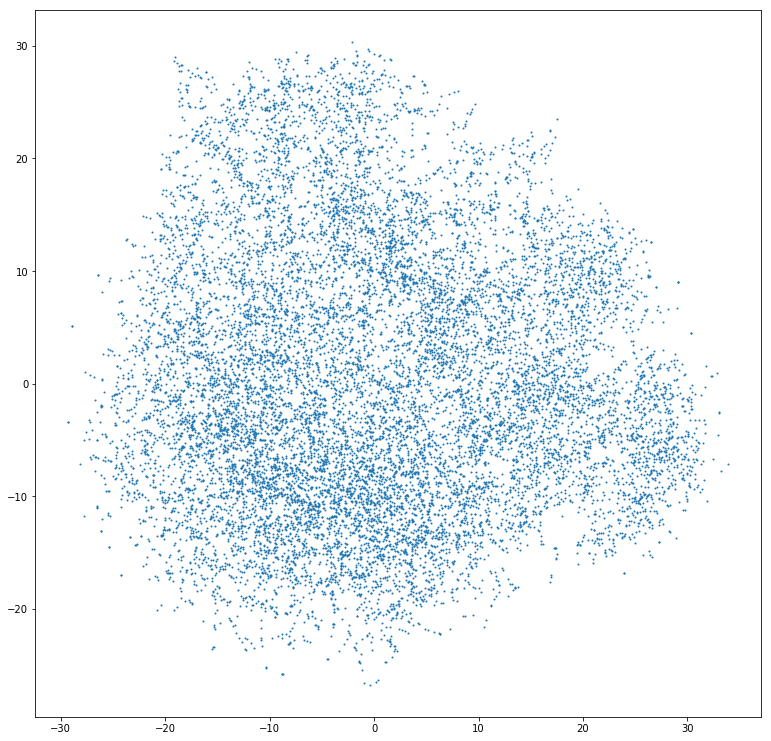

In [38]:
plt.figure(figsize=(13, 13))
perplexity = 50
# plt.scatter(vec2d[perplexity].T[0], vec2d[perplexity].T[1], s=1);
plt.scatter(vec3d.T[0], vec3d.T[1], s=1);

### Scenes

#### Scene1

In [90]:
len(scene['color'])

60912

In [91]:
cmap = mpl.cm.get_cmap('brg')
vec1dsorted = np.sort(vec1d[30][:, 0])

scene = {
    'count': 0,
    'token': [],
    'text': [],
    'pos': [],
    'color': [],
    'size': [],
}

for token_pos, token in enumerate(token_order):
    entry = data[token]
    scene['count'] += 1
    scene['token'].append(entry['token'])
    scene['text'].append(entry['ngram'])
    scene['pos'].extend(map(float, vec3d[token_pos, :]))
    rank = np.searchsorted(vec1dsorted, vec1d[30][token_pos, 0])
    scene['color'].extend(cmap(rank / len(vec1dsorted)))
    scene['size'].append(1)

json.dump(scene, open('../renderer/scenes/scene1.data.json', 'w'), ensure_ascii=False)